In [41]:
# MY SIMULATION 
import itertools
%matplotlib inline
import os
from shapely import Polygon
import random 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import vertex_model as model
# from vertex_model.run_select_nosaveinfo import run_simulation_INM, definecolors, run_simulation_no_INM
import itertools
import numpy as np
import matplotlib.pyplot as plt
import vertex_model as model
import vertex_model.initialisation as init
import vertex_model.characterization as crt
import vertex_model.save_data as save
from vertex_model.forces import TargetArea, Tension, Perimeter, Pressure
import os
import seaborn as sns
import warnings
import matplotlib.colors as colors
warnings.filterwarnings('ignore') #Don't show warnings
#from Gobal_Constant import dt, viscosity, t_G1, t_G2, t_S, A_c, J, pos_d, T1_eps, P, microns, time_hours, expansion_constant #file with necessary constants
from vertex_model.run_select import save_data
sns.set_style("whitegrid")
from scipy.spatial import Delaunay
import math
from scipy.spatial import ConvexHull

In [55]:
def cell_vertices(mesh, id):    
    cell_i = []
    for i in range(len(mesh.face_id_by_edge)):
        if mesh.face_id_by_edge[i] == id:
            cell_i.append(i)
    return cell_i
def centroid2(vertexes_x, vertexes_y):   
     _len = len(vertexes_x)
     _x = sum(vertexes_x) / _len
     _y = sum(vertexes_y) / _len
     return(_x, _y)

def mesh_centres(mesh):
    '''
    Compute the centres of the cells of a given mesh 
    '''
    centres_x =[]
    centres_y = [] 
    centres =np.zeros((mesh.n_face, 2))
    for i in range(mesh.n_face):       
       cell_i = cell_vertices(mesh, i) #vertices of the ith cell 
       area_i = mesh.area[i]
       if len(mesh.vertices[0][cell_i]) != 0:
        cell_center_i = centroid(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i])
        centres_x.append(cell_center_i[0])
        centres_y.append(cell_center_i[1])
        #centres.append(np.array([cell_center_i[0],cell_center_i[1] ]))
        centres[i, 0] = cell_center_i[0]
        centres[i, 1] = cell_center_i[1]
    return centres_x, centres_y, centres
def circumcenter(vertices):
    hull = ConvexHull(vertices)
    edges = hull.points[hull.simplices]

    circumcenters = []
    for edge in edges:
        x1, y1 = edge[0]
        x2, y2 = edge[1]
        x3, y3 = edge[2]

        A = np.array([[x2 - x1, y2 - y1], [x3 - x1, y3 - y1]])
        b = 0.5 * np.array([[(x2 - x1) ** 2 + (y2 - y1) ** 2], [(x3 - x1) ** 2 + (y3 - y1) ** 2]])
        try:
            circumcenter = np.linalg.solve(A, b)
            circumcenter = [circumcenter[0][0] + x1, circumcenter[1][0] + y1]
            circumcenters.append(circumcenter)
        except np.linalg.LinAlgError:
            pass

    circumcenter = np.mean(circumcenters, axis=0)
    return circumcenter



In [3]:
def draw_edges(mesh, ax):
    w1 = mesh.vertices
    r = mesh.edges.rotate
    w2 =  mesh.vertices.take(r, 1) 
    w = w1-w2 # winding
    to_draw = mesh.edges.ids[(mesh.edges.ids < mesh.edges.reverse) | (np.abs(w[0])+np.abs(w[1]) > 0.1)]
    start, end = mesh.vertices.take(to_draw, 1), mesh.vertices.take(mesh.edges.next[to_draw], 1)
 
    n = np.empty(len(start[0]))
    n.fill(np.nan)
    x = np.dstack([start[0], end[0], n]).ravel()
    y = np.dstack([start[1], end[1], n]).ravel()

    a = x[0:3]
    b = y[0:3]
    
    #ax.plot(a,b, 'k-', linewidth=1.0, color='green')
    return x, y

In [33]:
def centroid_polygon2(cell_area, vx, vy):
    n = len(vx)
    v_x = vx.tolist(); v_y = vy.tolist()
    v_x.append(v_x[0]); v_y.append(v_y[0])
    x = 0; y =0
    for i in range(n):
        a = (v_x[i]);    b = v_x[i+1]; c=v_y[i]; d = v_y[i+1]
        x = x + ((a+b)*(a*d-b*c))
        y = y +  ((v_y[i]+v_y[i+1])*(v_x[i]*v_y[i+1]-v_x[i+1]*v_y[i]))
    x = x /(6*cell_area);     y = y /(6*cell_area); 
    return (x, y)

In [12]:
ncellup = 10; ncellacross = 10; noise = 0.2

In [13]:
hex_centres = init.hexagonal_centres(ncellup   , ncellacross, noise, rand= np.random.RandomState())
mesh = init.toroidal_ic_mesh(hex_centres)
x, y = draw_edges(mesh, plt) 

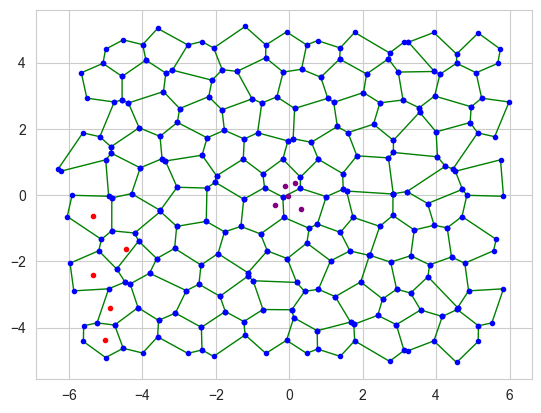

In [38]:
a = x[0:-1]
b = y[0:-1]
plt.plot(a,b, 'k-', linewidth=1.0, color='green')
plt.plot(hex_centres[0][:,0], hex_centres[0][:, 1], '.',color='red')
plt.plot(mesh.vertices[0], mesh.vertices[1], '.', color = 'blue')
b = mesh.boundary_faces
x_centers = []
y_centers = []
my_centres  =[]
for i in range(mesh.n_face):
    cell_i = cell_vertices(mesh, i)
    #plt.plot(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i], '.', color ='black')
    cell_area_i = mesh.area[i]
    cell_center_i = centroid_polygon2(cell_area_i,mesh.vertices[0][cell_i], mesh.vertices[1][cell_i])
    plt.plot(cell_center_i[0],cell_center_i[1], '.', color ='purple')
    x_centers.append(cell_center_i[0])
    y_centers.append(cell_center_i[1])
    my_centres.append([cell_center_i[0],cell_center_i[1]])

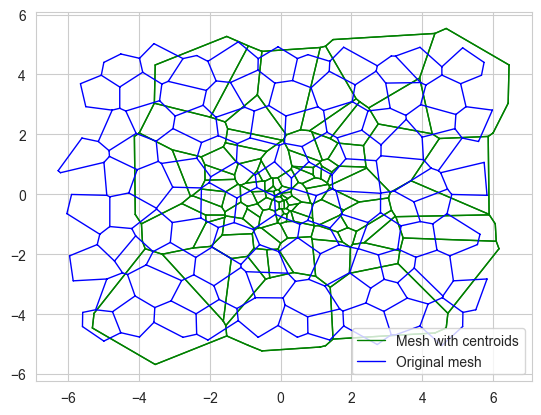

In [35]:
inicial = (np.array(my_centres), ncellup, ncellacross)
my_mesh = init.toroidal_ic_mesh(inicial)
model.plotting._draw_edges(my_mesh, plt) 
x2, y2 = draw_edges(my_mesh, plt)
a2 = x2[0:-1]
b2 = y2[0:-1]
plt.plot(a2,b2, 'k-', linewidth=1.0, color='green', label = 'Mesh with centroids')
a = x[0:-1]
b = y[0:-1]
plt.plot(a,b, 'k-', linewidth=1.0, color='blue', label='Original mesh')
plt.legend()

[-0.6721401  -0.17447436 -1.2379039  -0.1459158  -1.31452024 -0.78010204] [ 0.22761016 -0.05990072 -0.12407063 -0.67103459 -0.94487846 -1.17184664]
[(-0.6721401016455684, 0.2276101642786647), (-0.17447435767427286, -0.059900722850124155), (-1.2379038988798832, -0.12407062958994836), (-0.14591579981397876, -0.6710345932372096), (-1.3145202413243129, -0.9448784627383306), (-0.7801020394423587, -1.171846640726745)]
POINT (1.574522380034917 1.056739340960815)
(-0.7208427397967291, -0.4573534808106155)


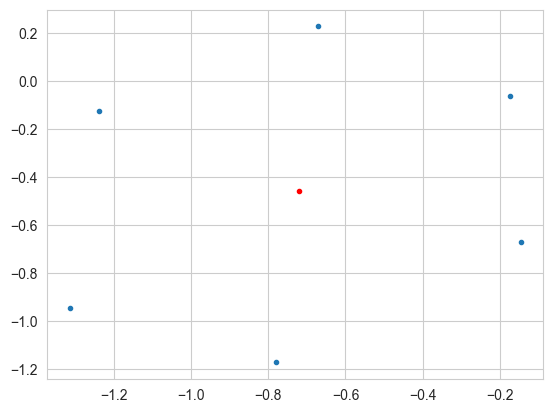

In [60]:
vertices= cell_vertices(mesh, 4)
xv = mesh.vertices[0][cell_i]
yv = mesh.vertices[1][cell_i]
print(xv, yv)
plt. plot(xv, yv, '.')
v = []
for i in range(len(xv)): 
    a = xv[i]; b = yv[i]
    v.append((a,b))
print(v)
polygon = Polygon(v)
c= polygon.centroid; print(c)
c2 = centroid2(xv, yv); print(c2); 
plt.plot(c2[0], c2[1], 'r.')
